In [1]:
from glob import iglob
from datetime import datetime
from itertools import chain, repeat

import numpy as np
import pandas as pd
from cytoolz import compose, reduce
from h5py import File
from dask import delayed, compute
from dask.bag import from_sequence
from dask.diagnostics import ProgressBar
import matplotlib.pyplot as plt

In [2]:
def is_available(filename):
    try:
        with File(filename, 'r'):
            pass
        return True
    except Exception:
        return False


def read_tof(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'tof': tof.astype('double')}
                        for tag, tof
                        in zip(f['/bunches'],
                               f['/digitizer/channel1']))
        except KeyError:
            yield from ()

In [4]:
run = 22
filenames = sorted(fn for fn in set(iglob(f"/data/Test/Run_{run:03d}/rawdata/*.h5")) if is_available(fn))
writein = f"/data/Test/Run_{run:03d}/work"
bg_period, bg_mod = 3, 0  # /Background_Period

integ = (
    from_sequence(filenames)
    .map(read_tof)
    .flatten()
    .to_dataframe()
)
integ['is_bg'] = integ['tag'] % bg_period == bg_mod

with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg,
                'count': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().count()),
                'summed': delayed(integ[integ['is_bg'] == bg]['tof'].to_bag().sum()),
            }
            for bg in [True, False]
        ],
    )

summed = pd.DataFrame(list(summed)).set_index('is_bg')
summed

[########################################] | 100% Completed | 45.1s


,count,summed
is_bg,,
True,8657,"[3826481.0, 3826561.0, 3826465.0, 3826531.0, 3..."
False,17315,"[7653487.0, 7653555.0, 7653567.0, 7653405.0, 7..."


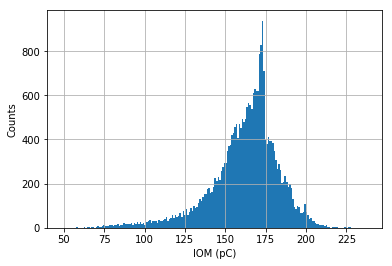

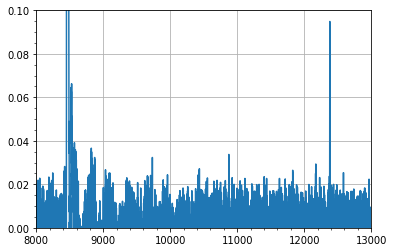

In [12]:
plt.hist(df["iom_intensity_pc"], bins=200)
plt.xlabel("IOM (pC)")
plt.ylabel("Counts")
plt.grid(True)
plt.show()

avg = (
    summed.loc[False, 'summed'] / summed.loc[False, 'count']
    - summed.loc[True, 'summed'] / summed.loc[True, 'count']
)
plt.plot(-avg)
plt.xlim(8000, 13000)
plt.ylim(0, 0.1)
plt.minorticks_on()
plt.grid(True)
plt.show()

In [6]:
def read_scala(filename):
    with File(filename, 'r') as f:
        try:
            yield from ({'tag': tag,
                         'iom_intensity_pc': iom,
                         'tof_intensity': tof[8000:9000].sum(),
                         'delay': round(dt, 2)}
                        for tag, iom, tof, dt
                        in zip(f['/bunches'],
                               f['/photon_diagnostics/FEL01'
                                 '/I0_monitor/iom_sh_a_pc'],
                               f['/digitizer/channel1'],
                               f['/user_laser/delay_line/position']))
        except KeyError:
            yield from ()


with ProgressBar():
    df = (
        from_sequence(filenames)
        .map(read_scala)
        .flatten()
        .to_dataframe()
        .compute()
    )
df

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  1min  0.1s


,delay,iom_intensity_pc,tag,tof_intensity
0,-6.00,172.303391,476855430,441946
1,-6.00,156.604958,476855431,441594
2,-6.00,165.560532,476855432,441571
3,-6.00,177.612877,476855433,441967
4,-6.00,192.138863,476855434,441671
5,-6.00,195.724869,476855435,441419
6,-6.00,189.702988,476855436,441988
7,-6.00,180.278778,476855437,441530
8,-6.00,211.691093,476855438,441364
9,-6.00,171.666527,476855439,441880


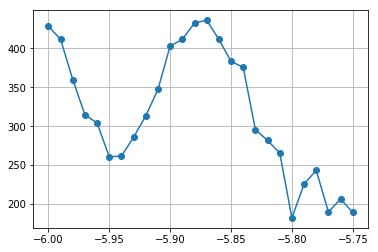

In [8]:
df['is_bg'] = df['tag'] % bg_period == bg_mod
groupped = df.groupby(['delay', 'is_bg'])['tof_intensity'].agg(['count', 'sum'])
diff = -(
    (groupped.loc[pd.IndexSlice[:, False], 'sum'] / groupped.loc[pd.IndexSlice[:, False], 'count']).reset_index(level=1, drop=True)
    - (groupped.loc[pd.IndexSlice[:, True], 'sum'] / groupped.loc[pd.IndexSlice[:, True], 'count']).reset_index(level=1, drop=True)
)
plt.figure()
plt.plot(diff, 'o-')
plt.grid(True)
plt.show()

In [14]:
ddf = (
    from_sequence(filenames)
    .map(read_tof)
    .flatten()
    .to_dataframe()
    .merge(df, on='tag')
)
where = (
    50 < ddf['iom_intensity_pc']
)

with ProgressBar():
    summed = compute(
        *[
            {
                'is_bg': bg, 'delay': dt,
                'count': delayed(ddf[where & (ddf['is_bg'] == bg) & (ddf['delay'] == dt)]['tof'].to_bag().count()),
                'summed': delayed(ddf[where & (ddf['is_bg'] == bg) & (ddf['delay'] == dt)]['tof'].to_bag().sum()),
            }
            for bg in [True, False] for dt in df["delay"].unique()
        ],
    )

summed = pd.DataFrame(list(summed)).set_index(['delay', 'is_bg'])
summed

[########################################] | 100% Completed |  1min 27.2s


,,count,summed
delay,is_bg,,
-6.00,True,334,"[147609.0, 147611.0, 147604.0, 147637.0, 14762..."
-5.99,True,333,"[147167.0, 147190.0, 147151.0, 147185.0, 14714..."
-5.98,True,333,"[147167.0, 147168.0, 147175.0, 147157.0, 14717..."
-5.97,True,333,"[147182.0, 147193.0, 147170.0, 147200.0, 14715..."
-5.96,True,325,"[143680.0, 143663.0, 143652.0, 143657.0, 14366..."
-5.95,True,333,"[147179.0, 147190.0, 147187.0, 147186.0, 14716..."
-5.94,True,333,"[147190.0, 147195.0, 147177.0, 147186.0, 14718..."
-5.93,True,333,"[147193.0, 147180.0, 147200.0, 147169.0, 14719..."
-5.92,True,333,"[147177.0, 147193.0, 147188.0, 147193.0, 14718..."


In [17]:
avg = {
    k: {'bg_n': summed.loc[(k, True), 'count'],
        'bg_tof': summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count'],
        'sg_n': summed.loc[(k, False), 'count'],
        'sg_tof': summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count'],
        'df_n': summed.loc[(k, False), 'count'],
        'df_tof': (summed.loc[(k, False), 'summed'] / summed.loc[(k, False), 'count']
                   - summed.loc[(k, True), 'summed'] / summed.loc[(k, True), 'count'])}
    for k in df["delay"].unique()
}

for k, d in avg.items():
    with File(f"{writein}/reduced_dt={k}.h5", "w") as f:
        f['bg_n'] = d['bg_n']
        f['bg_tof'] = d['bg_tof']
        f['sg_n'] = d['sg_n']
        f['sg_tof'] = d['sg_tof']
        f['df_n'] = d['df_n']
        f['df_tof'] = d['df_tof']